In [26]:
import numpy as np
import random 
import pandas as pd
import pyomo
import pyomo.environ as env
import networkx as nx
import matplotlib.pyplot as plt

def create_random_distance_matrix(n):
# Creating a distance matrix that follows the triangle inequality
    matrix = np.zeros((n, n), dtype=int)

    for i in range(n):
        for j in range(i + 1, n):
            matrix[i, j] = random.randint(50, 100)

    for i in range(n):
        for j in range(i + 1, n):
            for k in range(j + 1, n):
                matrix[j, k] = random.randint(50, 100)
                while matrix[i, j] + matrix[j, k] < matrix[i, k]:
                    matrix[i, k] = random.randint(50, 100)

    matrix = matrix + matrix.T
        
    return matrix

In [33]:
matrix = create_random_distance_matrix(30)

In [34]:
pd.DataFrame(matrix)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,90,54,56,60,60,81,84,87,67,...,71,90,73,72,92,91,57,92,99,94
1,90,0,64,58,86,78,83,66,76,61,...,100,61,80,71,68,99,60,75,92,84
2,54,64,0,97,78,65,76,72,52,77,...,51,79,62,59,97,67,98,65,86,56
3,56,58,97,0,60,100,63,76,100,84,...,77,99,86,93,75,56,68,97,88,96
4,60,86,78,60,0,89,90,61,76,74,...,73,71,53,62,98,56,51,84,57,55
5,60,78,65,100,89,0,86,53,95,56,...,88,96,100,52,52,66,51,83,57,94
6,81,83,76,63,90,86,0,54,84,72,...,99,97,74,79,64,54,95,100,99,59
7,84,66,72,76,61,53,54,0,78,57,...,66,53,90,58,74,96,84,91,57,65
8,87,76,52,100,76,95,84,78,0,72,...,100,55,66,79,65,57,64,82,73,86
9,67,61,77,84,74,56,72,57,72,0,...,84,66,71,69,54,87,80,92,61,95


In [18]:
class Optimization:
    
    def __init__(self, cost_matrix, num_cities, num_drivers=3):
        self.cost_matrix = cost_matrix
        self.num_cities = num_cities
        self.num_drivers = num_drivers
        
    def model(self):
        self.model = env.ConcreteModel()
        self.model.M = env.RangeSet(self.num_cities)  
        self.model.N = env.RangeSet(self.num_cities) 
        self.model.U = env.RangeSet(2, self.num_cities) 
        
        self.model.x = env.Var(self.model.N, self.model.M, within=env.Binary)
        
        self.model.u = env.Var(self.model.N, within=env.NonNegativeIntegers, bounds=(0, self.num_cities-1))
        self.model.c = env.Param(self.model.N, self.model.M, initialize=lambda model, i, j: self.cost_matrix[i-1][j-1])
        
        self.model.num_cities = self.num_cities   # Store num_cities in the model
        self.model.num_drivers = self.num_drivers  # Store num_drivers in the model
        
        self.model.objective = env.Objective(rule=self.__obj_func, sense=env.minimize)
        
        if self.model.num_drivers == 1:
            self.model.rest1 = env.Constraint(self.model.M, rule=self.__rule_const1)
            self.model.rest2 = env.Constraint(self.model.N, rule=self.__rule_const2)
            self.model.rest3 = env.Constraint(self.model.U, self.model.N, rule=self.__rule_const6)

        else:
            self.model.rest1 = env.Constraint(self.model.M - [1], rule=self.__rule_const1)
            self.model.rest2 = env.Constraint(self.model.N - [1], rule=self.__rule_const2)
            self.model.rest4 = env.Constraint(self.model.N, rule=self.__rule_const4)
            self.model.rest5 = env.Constraint(self.model.M, rule=self.__rule_const5)
            self.model.rest3 = env.Constraint(self.model.U, self.model.N, rule=self.__rule_const3)
        
    @staticmethod
    def __obj_func(model):
        return sum(model.x[i, j] * model.c[i, j] for i in model.N for j in model.M)
    
    @staticmethod
    def __rule_const1(model, M):
        return sum(model.x[i, M] for i in model.N if i != M) == 1
    
    @staticmethod
    def __rule_const2(model, N):
        return sum(model.x[N, j] for j in model.M if j != N) == 1
    
    @staticmethod
    def __rule_const4(model, M):
        return sum(model.x[i, 1] for i in model.M if i != 1) == model.num_drivers

    @staticmethod
    def __rule_const5(model, N):
        return sum(model.x[1, j] for j in model.M if j != 1) == model.num_drivers


    @staticmethod
    def __rule_const3(model, i, j):
        if i != j: 
            return model.u[i] - model.u[j] + model.x[i, j] * (model.num_cities - model.num_drivers - 1)  <= model.num_cities - model.num_drivers - 3
        else:
            return model.u[i] - model.u[i] == 0 
        
    @staticmethod
    def __rule_const6(model, i, j):
        if i != j: 
            return model.u[i] - model.u[j] + model.x[i, j] * model.num_cities <= model.num_cities - 1
        else:
            return model.u[i] - model.u[i] == 0  
        
    
    def print_model(self):
        self.model.pprint()
    
    def solve_model(self):
        solver = env.SolverFactory('cplex')
        result = solver.solve(self.model)
        print(result)
    
    def print_output(self):
        List = list(self.model.x.keys())
        valid_list = []
        for i in List:
            if self.model.x[i]() is not None and self.model.x[i]() != 0:
                valid_list.append(i)

        # Create a graph
        G = nx.Graph()

        edges = valid_list
        # Add edges to the graph
        G.add_edges_from(edges)

        # Calculate the positions of the nodes using a spring layout
        pos = nx.spring_layout(G)

        # Define visualization options
        options = {
            "font_size": 5,
            "node_size": 100,
            "node_color": "white",
            "edgecolors": "black",
            "linewidths": 1,
            "width": 1,
        }

        # Draw the graph with options
        nx.draw_networkx(G, pos, **options)

        # Adjust margins before disabling axes
        ax = plt.gca()        
        ax.margins(0.20)

        # Turn off axes and show the plot
        plt.axis("off")
        plt.show()

In [20]:
opt = Optimization(matrix, len(matrix), 1)
opt.model()
opt.solve_model()
opt.print_model()



Problem: 
- Name: tmpa5lb34ps
  Lower bound: 1547.0
  Upper bound: 1547.0
  Number of objectives: 1
  Number of constraints: 930
  Number of variables: 901
  Number of nonzeros: 4263
  Sense: minimize
Solver: 
- Status: ok
  User time: 0.83
  Termination condition: optimal
  Termination message: MIP - Integer optimal solution\x3a Objective = 1.5470000000e+03
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 1.0283019542694092
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

3 Set Declarations
    c_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    N*M :  900 : {(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 

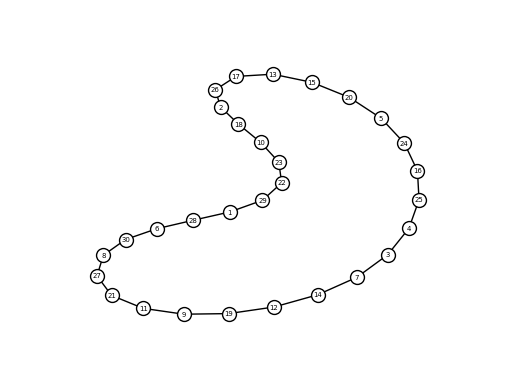

In [21]:
opt.print_output()

In [22]:
opt = Optimization(matrix, len(matrix), 3)
opt.model()
opt.solve_model()
opt.print_model()



Problem: 
- Name: tmp6_jk4e_i
  Lower bound: 1659.0
  Upper bound: 1659.0
  Number of objectives: 1
  Number of constraints: 988
  Number of variables: 901
  Number of nonzeros: 5945
  Sense: minimize
Solver: 
- Status: ok
  User time: 1.23
  Termination condition: optimal
  Termination message: MIP - Integer optimal solution\x3a Objective = 1.6590000000e+03
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 401
      Number of created subproblems: 401
  Error rc: 0
  Time: 1.399052619934082
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

7 Set Declarations
    c_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    N*M :  900 : {(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (

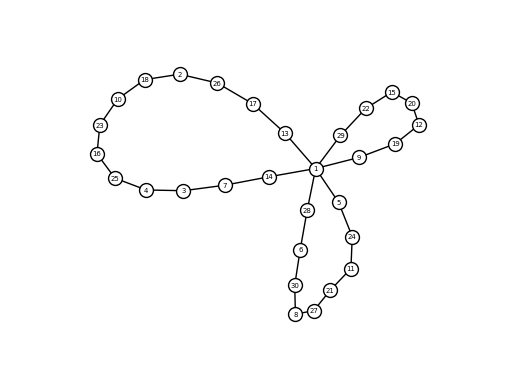

In [25]:
opt.print_output()